In [2]:
# find files recursively
from glob import glob

# parse tb files
from tbparse import SummaryReader

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# searching df rows with np.where()
import numpy as np
import pandas as pd

import re 

from scipy import stats
import tensorboard as tb
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

2024-10-31 23:30:06.519876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730413806.595363   32533 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730413806.617156   32533 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 23:30:06.794629: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def extract_tb_values(logdir, value_name, print_tags = False):
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()
    
    if print_tags:
        print(event_acc.Tags()['scalars'])
        
    if value_name not in event_acc.Tags()['scalars']:
        print("Scalar {} not found.".format(value_name))
        return [], [], []
    else:
        events = event_acc.Scalars(value_name)
    
    steps = [event.step for event in events]
    values = [event.value for event in events]
    wall_time = [event.wall_time for event in events]
    
    return values, steps, wall_time

In [4]:
def get_rolling_avg(values, window_size):
    return np.convolve(values, np.ones(window_size) / window_size, mode = 'valid')

In [5]:
def get_names_meeting_env(logdir_list):
    name_list = []
    for file_name in logdir_list:
        # name = re.sub("training/meeting_training/((s)?\d/)?", "", re.sub("/tensorboard_logs/.*", "",  file_name))
        name = re.sub("training/meeting_training/((s)?\d/)?", "", re.sub("((_\d)|(_75))?/tensorboard_logs/.*", "",  file_name))
        name_list.append(name)
        
    return name_list

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_32533/3849543365.py:5: SyntaxWarning: invalid escape sequence '\d'
  name = re.sub("training/meeting_training/((s)?\d/)?", "", re.sub("((_\d)|(_75))?/tensorboard_logs/.*", "",  file_name))
/tmp/ipykernel_32533/3849543365.py:5: SyntaxWarning: invalid escape sequence '\d'
  name = re.sub("training/meeting_training/((s)?\d/)?", "", re.sub("((_\d)|(_75))?/tensorboard_logs/.*", "",  file_name))


In [6]:
def get_df_in_steps(logdir_list, plot_names, value_name, rolling_avg_window = 1, wall_time_avg = False):
    df = pd.DataFrame()
    
    if wall_time_avg: 
        x = "wall_time"
    else:
        x = "steps"
        
    for (file_name, plot_name) in zip(logdir_list, plot_names):
        values, steps, wall_time = extract_tb_values(file_name, value_name)
        
        # replace some mismatched naming
        value_name_corrected = value_name.replace("reward/", "rollout/").replace("ep_len", "ep_steps")

        if values != []:
            value_dict = {value_name_corrected: values, 
                          "steps": steps, 
                          "wall_time": [(time - wall_time[0]) / 60. for time in wall_time]}
            
            temp_df = pd.DataFrame(value_dict)
            
            bin_edges = np.arange(0, temp_df[x].max() + rolling_avg_window, rolling_avg_window, dtype = np.int32)
            temp_df['bin'] = pd.cut(temp_df[x], bins = bin_edges, labels = bin_edges[:-1])

            def weighted_avg(group):
                if not np.isclose(group[x].sum(), 0.):
                    # Calculate the weighted average over the bins weighted by the steps
                    return pd.Series({
                        value_name_corrected: np.average(group[value_name_corrected], weights = group[x]),
                    })
                else:
                    return None

            temp_df = temp_df.groupby(['bin'], observed = False)[[value_name_corrected, "steps", "wall_time", "bin"]].apply(weighted_avg, include_groups = True).reset_index().dropna()
            
            # add missing bins
            all_bins = pd.DataFrame({'bin': bin_edges[:-1]})

            temp_df = pd.merge(all_bins, temp_df, on = 'bin', how = 'left')

            # interpolate missing values
            temp_df[value_name_corrected] = temp_df[value_name_corrected].interpolate()
            
            temp_df = temp_df.rename(columns = {"bin": x})
            temp_df["run"] = np.repeat(plot_name, len(temp_df.index))
            
            df = df._append(temp_df)
        
        print(plot_name + " done!")
     
    return df        

In [7]:
def get_tb_files(env_name, run_name_list):
    tb_files = []
    
    for run_name in run_name_list:
        for filename in glob(("training/" + env_name + "/" + run_name + "/**/events*"), recursive=True):
            if "agent" in filename:
                if "agent1" in filename:
                    tb_files.append(filename)
            else:
                tb_files.append(filename)
                
    return tb_files

# 7

In [44]:
run_list = [
    "seqdqn_7_1",
    "seqdqn_7_2",
    "seqdqn_7_3",
    "dqn_7_lllr_010",
]
tb_files = get_tb_files("meeting_training", run_list)
display(tb_files)

df_7ep_len = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_len", 500)
df_7 = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/eval_reward_sum", 500)

['training/meeting_training/seqdqn_7_1/tensorboard_logs/events.out.tfevents.1720038164.v100gpu14.391760.0',
 'training/meeting_training/seqdqn_7_1/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1720038166.v100gpu14.391760.2',
 'training/meeting_training/seqdqn_7_1/tensorboard_logs/train_avg_Q_target_value_agent1/events.out.tfevents.1720038168.v100gpu14.391760.23',
 'training/meeting_training/seqdqn_7_1/tensorboard_logs/train_avg_Q_value_agent1/events.out.tfevents.1720038168.v100gpu14.391760.16',
 'training/meeting_training/seqdqn_7_1/tensorboard_logs/train_average_loss_agent1/events.out.tfevents.1720038168.v100gpu14.391760.9',
 'training/meeting_training/seqdqn_7_2/tensorboard_logs/events.out.tfevents.1725364896.v100gpu15.718987.0',
 'training/meeting_training/seqdqn_7_2/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1725364898.v100gpu15.718987.2',
 'training/meeting_training/seqdqn_7_2/tensorboard_logs/train_avg_Q_target_value_agent1/events.out.tfevents

seqdqn_7 done!
Scalar rollout/ep_len not found.
seqdqn_7 done!
Scalar rollout/ep_len not found.
seqdqn_7 done!
Scalar rollout/ep_len not found.
seqdqn_7 done!
Scalar rollout/ep_len not found.
seqdqn_7 done!
seqdqn_7 done!
Scalar rollout/ep_len not found.
seqdqn_7 done!
Scalar rollout/ep_len not found.
seqdqn_7 done!
Scalar rollout/ep_len not found.
seqdqn_7 done!
Scalar rollout/ep_len not found.
seqdqn_7 done!
seqdqn_7 done!
Scalar rollout/ep_len not found.
seqdqn_7 done!
Scalar rollout/ep_len not found.
seqdqn_7 done!
Scalar rollout/ep_len not found.
seqdqn_7 done!
Scalar rollout/ep_len not found.
seqdqn_7 done!
dqn_7_lllr_010 done!
seqdqn_7 done!
Scalar rollout/eval_reward_sum not found.
seqdqn_7 done!
Scalar rollout/eval_reward_sum not found.
seqdqn_7 done!
Scalar rollout/eval_reward_sum not found.
seqdqn_7 done!
Scalar rollout/eval_reward_sum not found.
seqdqn_7 done!
seqdqn_7 done!
Scalar rollout/eval_reward_sum not found.
seqdqn_7 done!
Scalar rollout/eval_reward_sum not found.
s

In [45]:

df_7ep_len = df_7ep_len[df_7ep_len["steps"] < 100000]
df_7 = df_7[df_7["steps"] < 100000]

ValueError: Could not interpret value `rollout/ep_len` for `y`. An entry with this name does not appear in `data`.

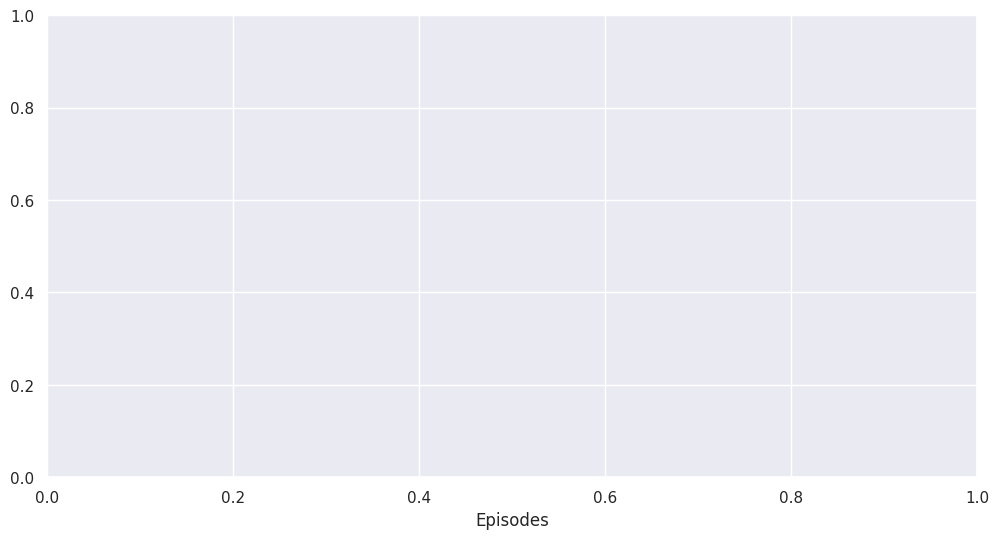

In [ ]:
sns.set_theme()

fig, ax1 = plt.subplots(figsize = (12, 6))

ax1.set_xlabel("Episodes")
sns.lineplot(df_7ep_len[df_7ep_len["run"] == "dqn_7"], x = "steps", y = "rollout/ep_steps", color = "tab:blue", label = "Reward (dqn)")
sns.lineplot(df_7ep_len[df_7ep_len["run"] == "seqdqn_7"], x = "steps", y = "rollout/ep_steps", color = "tab:green", label = "Reward (seqdqn)")

ax2 = ax1.twinx()
sns.lineplot(df_7[df_7["run"] == "dqn_7"], x = "steps", y = "rollout/eval_reward_sum", color = "tab:red", label = "Episode Length (dqn)", linestyle = "--")
sns.lineplot(df_7[df_7["run"] == "seqdqn_7"], x = "steps", y = "rollout/eval_reward_sum", color = "tab:orange", label = "Episode Length (seqdqn)", linestyle = "--")
ax1.tick_params(axis = "y", labelcolor = "tab:red")
ax2.tick_params(axis = "y", labelcolor = "tab:blue")

ax1.set_ylabel("Episode Length", color = "tab:red") 
ax2.set_ylabel("Average Reward", color = "tab:blue")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

/tmp/ipykernel_32533/1514875116.py:8: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)


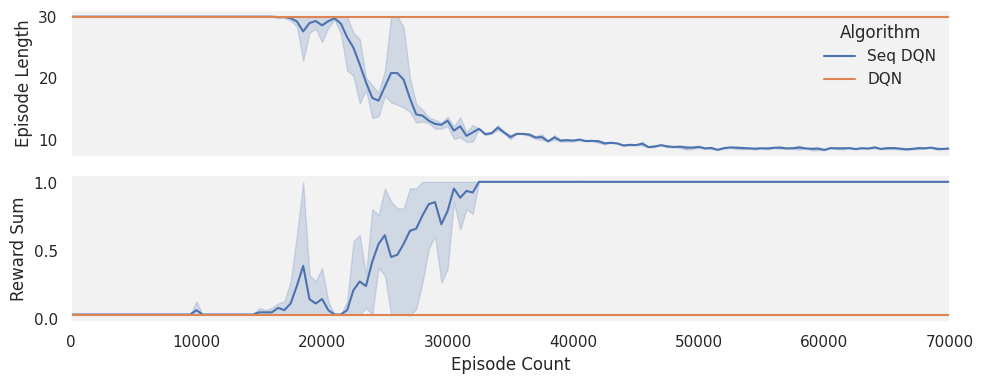

In [46]:
# sns.set_theme()
# sns.set_theme(style="dark", palette="pastel")
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(2, 1, figsize=(10,4), sharex = True)

sns.lineplot(df_7ep_len[df_7ep_len["steps"] <= 70000], x = "steps", y = "rollout/ep_steps", hue = "run", ax = axs[0])
axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)
axs[0].set_ylabel('Episode Length')
axs[0].margins(x=0)

sns.lineplot(df_7[df_7["steps"] <= 70000], x = "steps", y = "rollout/eval_reward_sum", hue = "run", ax = axs[1], legend = False)
axs[1].set_ylabel('Reward Sum')
axs[1].set_xlabel('Episode Count')
axs[1].margins(x=0)

plt.tight_layout()
plt.show()

fig.savefig('plots/meeting_7_DQN.png', dpi = 300)

<Axes: xlabel='steps', ylabel='rollout/eval_reward_sum'>

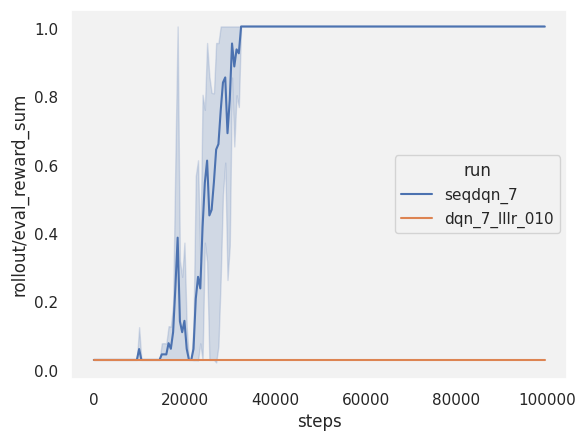

In [ ]:
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})
sns.lineplot(df_7, x = "steps", y = "rollout/eval_reward_sum", hue = "run")

<Axes: xlabel='steps', ylabel='rollout/ep_len'>

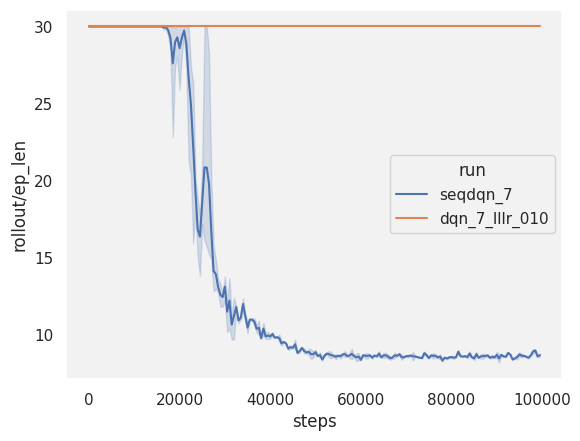

In [ ]:
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})
sns.lineplot(df_7ep_len, x = "steps", y = "rollout/ep_steps", hue = "run")

# 5

In [ ]:

run_list = [
    "seqdqn_5_2",
    "seqdqn_5_3",
    "seqdqn_5_75",
    "dqn_5_llr_10",
    "dqn_5_llr_10_2",
]
tb_files = get_tb_files("meeting_training", run_list)
display(tb_files)

df_5ep_len = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_len", 450)
df_5 = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/eval_reward_sum", 450)

df_5ep_len_wt = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_len", 3.75, True)
df_5_wt = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/eval_reward_sum", 3.75, True)

['training/meeting_training/seqdqn_5_2/tensorboard_logs/events.out.tfevents.1725635782.v100gpu21.1704557.0',
 'training/meeting_training/seqdqn_5_2/tensorboard_logs/train_avg_Q_target_value_agent1/events.out.tfevents.1725635785.v100gpu21.1704557.17',
 'training/meeting_training/seqdqn_5_2/tensorboard_logs/train_average_loss_agent1/events.out.tfevents.1725635785.v100gpu21.1704557.7',
 'training/meeting_training/seqdqn_5_2/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1725635784.v100gpu21.1704557.2',
 'training/meeting_training/seqdqn_5_2/tensorboard_logs/train_avg_Q_value_agent1/events.out.tfevents.1725635785.v100gpu21.1704557.12',
 'training/meeting_training/seqdqn_5_3/tensorboard_logs/events.out.tfevents.1727430044.v100gpu5.1225394.0',
 'training/meeting_training/seqdqn_5_3/tensorboard_logs/train_average_loss_agent1/events.out.tfevents.1727430047.v100gpu5.1225394.7',
 'training/meeting_training/seqdqn_5_3/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.

seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
dqn_5_llr_10 done!
dqn_5_llr_10 done!
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
dqn_5_llr_10 done!
dqn_5_llr_10 done!
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
Scalar not found.
seqdqn_5 done!
seqdqn_5 done!
Scalar not f

/tmp/ipykernel_970379/2037469102.py:11: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)


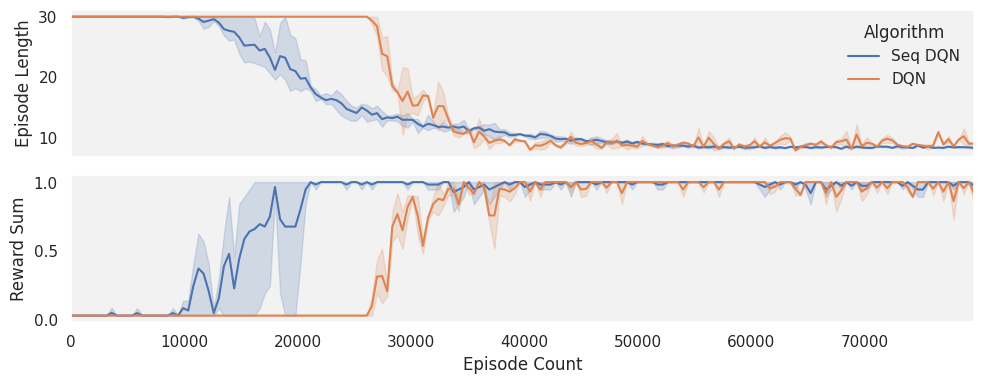

In [ ]:
df_5 = df_5[df_5["steps"] < 100000]
df_5ep_len = df_5ep_len[df_5ep_len["steps"] < 100000]

# sns.set_theme()
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(2, 1, figsize=(10,4), sharex = True)


sns.lineplot(df_5ep_len[df_5ep_len["steps"] <= 80000], x = "steps", y = "rollout/ep_steps", hue = "run", ax = axs[0])
axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)
axs[0].set_ylabel('Episode Length')
axs[0].margins(x=0)

sns.lineplot(df_5[df_5["steps"] <= 80000], x = "steps", y = "rollout/eval_reward_sum", hue = "run", ax = axs[1], legend = False)
axs[1].set_ylabel('Reward Sum')
# axs[1].grid(axis = "y")
axs[1].set_xlabel('Episode Count')
axs[1].margins(x=0)

plt.tight_layout()
plt.show()

fig.savefig('plots/meeting_5_DQN.png', dpi = 300)

/tmp/ipykernel_970379/1037181688.py:7: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)


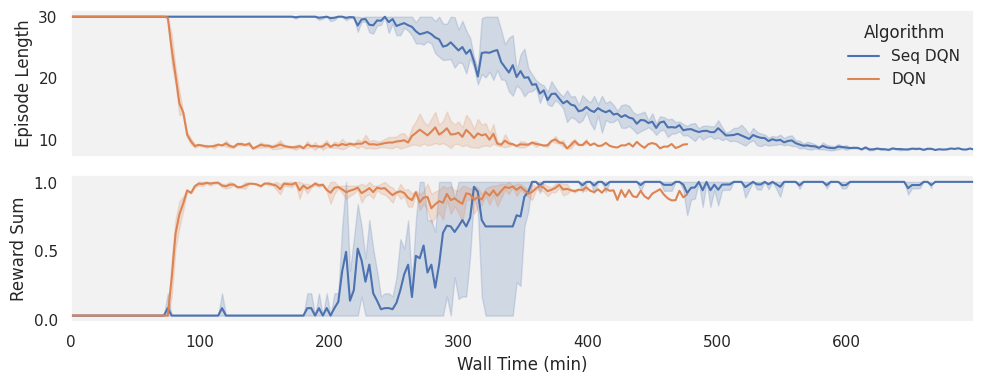

In [ ]:
# sns.set_theme()
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(2, 1, figsize=(10,4), sharex = True)

sns.lineplot(df_5ep_len_wt[df_5ep_len_wt["wall_time"] <= 700 ], x = "wall_time", y = "rollout/ep_len", hue = "run", ax = axs[0], legend = ["Simultaneous DQN", "Agent-by-Agent DQN"])
axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)
axs[0].set_ylabel('Episode Length')
axs[0].margins(x=0)

sns.lineplot(df_5_wt[df_5_wt["wall_time"] <= 700], x = "wall_time", y = "rollout/eval_reward_sum", hue = "run", ax = axs[1], legend = False)
axs[1].set_ylabel('Reward Sum')
axs[1].set_xlabel('Wall Time (min)')
axs[1].margins(x=0)

plt.tight_layout()
plt.show()

# fig.savefig('plots/meeting_5_DQN_wt.png', dpi = 300)

/tmp/ipykernel_970379/4258596728.py:7: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)


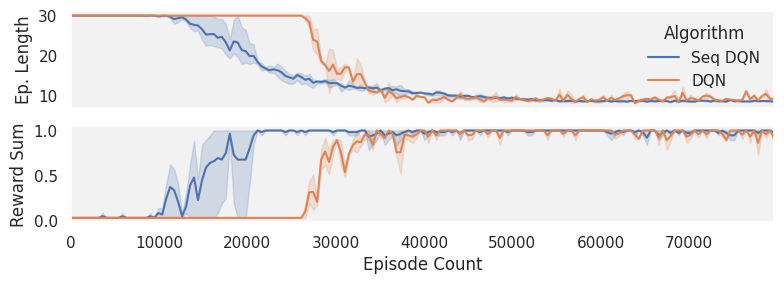

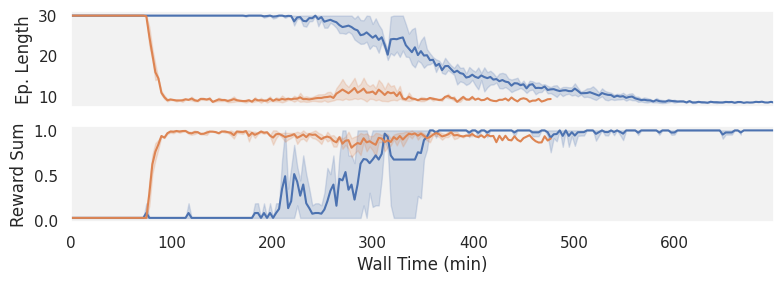

In [ ]:
# sns.set_theme()
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig1, axs = plt.subplots(2, 1, figsize=(8,3), sharex = True)

sns.lineplot(df_5ep_len[df_5ep_len["steps"] <= 80000], x = "steps", y = "rollout/ep_steps", hue = "run", ax = axs[0])
axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)
axs[0].set_ylabel('Ep. Length')
axs[0].margins(x=0)

sns.lineplot(df_5[df_5["steps"] <= 80000], x = "steps", y = "rollout/eval_reward_sum", hue = "run", ax = axs[1], legend = False)
axs[1].set_ylabel('Reward Sum')
axs[1].set_xlabel('Episode Count')
axs[1].margins(x=0)

plt.tight_layout()
plt.show()

sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig2, axs = plt.subplots(2, 1, figsize=(8,3), sharex = True)

sns.lineplot(df_5ep_len_wt[df_5ep_len_wt["wall_time"] <= 700 ], x = "wall_time", y = "rollout/ep_steps", hue = "run", ax = axs[0], legend = False)
# axs[2].legend(title = "Algorithm", loc = "upper left", labels = ["Seq DQN", "_nolegend_", "DQN"])
axs[0].set_ylabel('Ep. Length')
axs[0].margins(x=0)

sns.lineplot(df_5_wt[df_5_wt["wall_time"] <= 700], x = "wall_time", y = "rollout/eval_reward_sum", hue = "run", ax = axs[1], legend = False)
axs[1].set_ylabel('Reward Sum')
axs[1].set_xlabel('Wall Time (min)')
axs[1].margins(x=0)

plt.tight_layout()
plt.show()

fig1.savefig('plots/meeting_5_DQN_wt1.png', dpi = 300)
fig2.savefig('plots/meeting_5_DQN_wt2.png', dpi = 300)

/tmp/ipykernel_970379/3858325248.py:16: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs[0][1].legend(title = "Algorithm", loc = "upper right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)


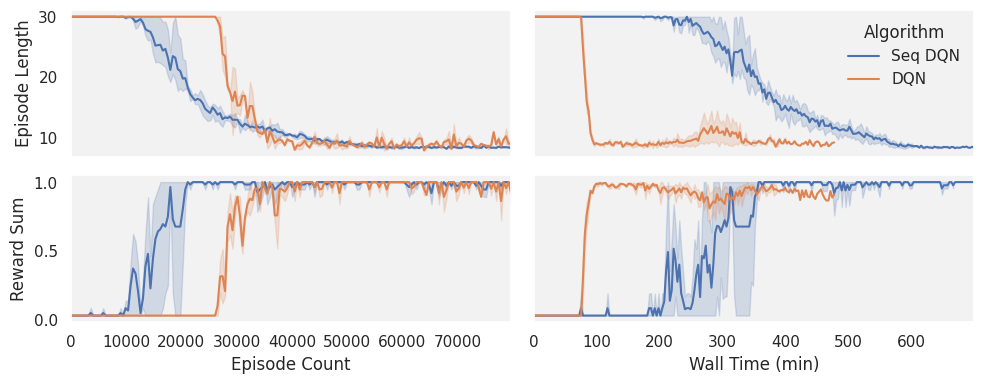

In [ ]:
# sns.set_theme()
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(2, 2, figsize=(10,4), sharex = "col", sharey = "row")

sns.lineplot(df_5ep_len[df_5ep_len["steps"] <= 80000], x = "steps", y = "rollout/ep_steps", hue = "run", ax = axs[0][0], legend = False)
axs[0][0].set_ylabel('Episode Length')
axs[0][0].margins(x=0)

sns.lineplot(df_5[df_5["steps"] <= 80000], x = "steps", y = "rollout/eval_reward_sum", hue = "run", ax = axs[1][0], legend = False)
axs[1][0].set_ylabel('Reward Sum')
axs[1][0].set_xlabel('Episode Count')
axs[1][0].margins(x=0)

sns.lineplot(df_5ep_len_wt[df_5ep_len_wt["wall_time"] <= 700 ], x = "wall_time", y = "rollout/ep_steps", hue = "run", ax = axs[0][1], legend = False)
axs[0][1].legend(title = "Algorithm", loc = "upper right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)
axs[0][1].set_ylabel('Episode Length')
axs[0][1].margins(x=0)


sns.lineplot(df_5_wt[df_5_wt["wall_time"] <= 700], x = "wall_time", y = "rollout/eval_reward_sum", hue = "run", ax = axs[1][1], legend = False)
axs[1][1].set_ylabel('Reward Sum')
axs[1][1].set_xlabel('Wall Time (min)')
axs[1][1].margins(x=0)

plt.tight_layout()
plt.show()

fig.savefig('plots/meeting_5_DQN_wt.png', dpi = 300)

# 3

In [ ]:
run_list = [
    "dqn_3_llr_50",
    "dqn_3_llr_50_1",
    "dqn_3_llr_50_2",
    "seqdqn_3_50",
    "seqdqn_3_50_2",
    "seqdqn_3_50_1",
]
tb_files = get_tb_files("meeting_training", run_list)
display(tb_files)
get_names_meeting_env(tb_files)

['training/meeting_training/dqn_3_llr_50/tensorboard_logs/events.out.tfevents.1724937920.v100gpu11.44692.0',
 'training/meeting_training/dqn_3_llr_50_1/tensorboard_logs/events.out.tfevents.1727111932.v100gpu29.830273.0',
 'training/meeting_training/dqn_3_llr_50_2/tensorboard_logs/events.out.tfevents.1727111939.v100gpu26.3758671.0',
 'training/meeting_training/seqdqn_3_50/tensorboard_logs/events.out.tfevents.1724944405.v100gpu1.1904406.0',
 'training/meeting_training/seqdqn_3_50/tensorboard_logs/train_avg_Q_target_value_agent1/events.out.tfevents.1724944408.v100gpu1.1904406.11',
 'training/meeting_training/seqdqn_3_50/tensorboard_logs/train_average_loss_agent1/events.out.tfevents.1724944408.v100gpu1.1904406.5',
 'training/meeting_training/seqdqn_3_50/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1724944408.v100gpu1.1904406.2',
 'training/meeting_training/seqdqn_3_50/tensorboard_logs/train_avg_Q_value_agent1/events.out.tfevents.1724944408.v100gpu1.1904406.8',
 'training/

['dqn_3_llr_50',
 'dqn_3_llr_50',
 'dqn_3_llr_50',
 'seqdqn_3_50',
 'seqdqn_3_50',
 'seqdqn_3_50',
 'seqdqn_3_50',
 'seqdqn_3_50',
 'seqdqn_3_50',
 'seqdqn_3_50',
 'seqdqn_3_50',
 'seqdqn_3_50',
 'seqdqn_3_50',
 'seqdqn_3_50']

In [ ]:
df_3ep_len = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_len", 500)
df_3 = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/eval_reward_sum", 500)

df_3 = df_3[df_3["steps"] < 100000]
df_3ep_len = df_3ep_len[df_3ep_len["steps"] < 100000]

dqn_3_llr_50 done!
dqn_3_llr_50 done!
dqn_3_llr_50 done!
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
dqn_3_llr_50 done!
dqn_3_llr_50 done!
dqn_3_llr_50 done!
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!


NameError: name 'df_3ep_len' is not defined

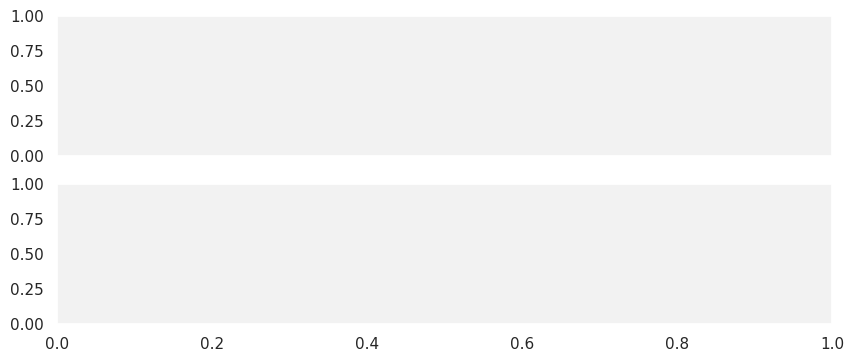

In [43]:
# sns.set_theme()
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"}) 

fig, axs = plt.subplots(2, 1, figsize=(10,4), sharex = True)

sns.lineplot(df_3ep_len, x = "steps", y = "rollout/ep_steps", hue = "run", ax = axs[0])
axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)
axs[0].set_ylabel('Episode Length')
axs[0].margins(x=0)
axs[0].set_ylim(0.)


sns.lineplot(df_3, x = "steps", y = "rollout/eval_reward_sum", hue = "run", ax = axs[1], 
             legend = False)
axs[1].set_ylabel('Reward Sum')
axs[1].set_xlabel('Episode Count')
axs[1].margins(x=0)
axs[0].set_ylim(0.)


plt.tight_layout()
plt.show()

fig.savefig('plots/meeting_3_DQN.png', dpi = 300)

dqn_3_llr_50 done!
dqn_3_llr_50 done!
dqn_3_llr_50 done!
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
dqn_3_llr_50 done!
dqn_3_llr_50 done!
dqn_3_llr_50 done!
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!
Scalar not found.
seqdqn_3_50 done!


/tmp/ipykernel_970379/1892665103.py:10: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs[0].legend(title = "Algorithm", loc = "upper left", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)


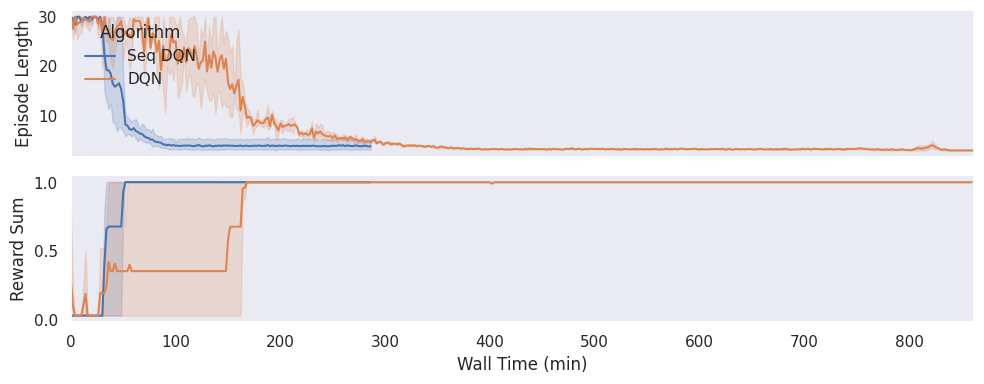

In [ ]:
df_3ep_len = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_len", 2.5, True)
df_3 = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/eval_reward_sum", 2.5, True)

# sns.set_theme()
sns.set_theme(style = "dark")

fig, axs = plt.subplots(2, 1, figsize=(10,4), sharex = True)

sns.lineplot(df_3ep_len, x = "wall_time", y = "rollout/ep_steps", hue = "run", ax = axs[0])
axs[0].legend(title = "Algorithm", loc = "upper left", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)
axs[0].set_ylabel('Episode Length')
axs[0].margins(x=0)

sns.lineplot(df_3, x = "wall_time", y = "rollout/eval_reward_sum", hue = "run", ax = axs[1], legend = False)
axs[1].set_ylabel('Reward Sum')
axs[1].set_xlabel('Wall Time (min)')
axs[1].margins(x=0)

plt.tight_layout()
plt.show()

fig.savefig('plots/meeting_3_DQN_wt.png', dpi = 300)

# 3 SAC

In [11]:

run_list = [
    "sac_3_1",
    "sac_3_2",
    "sac_3_3",
    "seqsac_3_1",
    "seqsac_3_2",
    "seqsac_3_3",
]
tb_files = get_tb_files("meeting_training", run_list)
display(tb_files)

df_ep_len = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_steps", 450)
df_ep_len = pd.concat([df_ep_len, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/ep_len", 450)])
df = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/reward_sum", 450)
df = pd.concat([df, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/reward_sum", 450)])

# df_ep_len_wt = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_len", 3.75, True)
# df__wt = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/eval_reward_sum", 3.75, True)

['training/meeting_training/sac_3_1/tensorboard_logs/events.out.tfevents.1729262446.v100gpu15.1007777.0',
 'training/meeting_training/sac_3_2/tensorboard_logs/events.out.tfevents.1729269402.v100gpu10.3503880.0',
 'training/meeting_training/sac_3_3/tensorboard_logs/events.out.tfevents.1729286091.v100gpu11.4033669.0',
 'training/meeting_training/seqsac_3_1/tensorboard_logs/events.out.tfevents.1729417867.v100gpu4.3755685.0',
 'training/meeting_training/seqsac_3_1/tensorboard_logs/train_avg_actor_loss_agent1/events.out.tfevents.1729418098.v100gpu4.3755685.5',
 'training/meeting_training/seqsac_3_1/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1729417868.v100gpu4.3755685.2',
 'training/meeting_training/seqsac_3_1/tensorboard_logs/train_avg_alpha_loss_agent1/events.out.tfevents.1729418098.v100gpu4.3755685.11',
 'training/meeting_training/seqsac_3_1/tensorboard_logs/train_avg_critic_loss_agent1/events.out.tfevents.1729418098.v100gpu4.3755685.8',
 'training/meeting_training/se

Scalar rollout/ep_steps not found.
sac_3 done!
Scalar rollout/ep_steps not found.
sac_3 done!
Scalar rollout/ep_steps not found.
sac_3 done!
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout

In [12]:
df["rollout/reward_sum"] = df["rollout/reward_sum"] / 1000 


/tmp/ipykernel_32533/830246535.py:7: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)


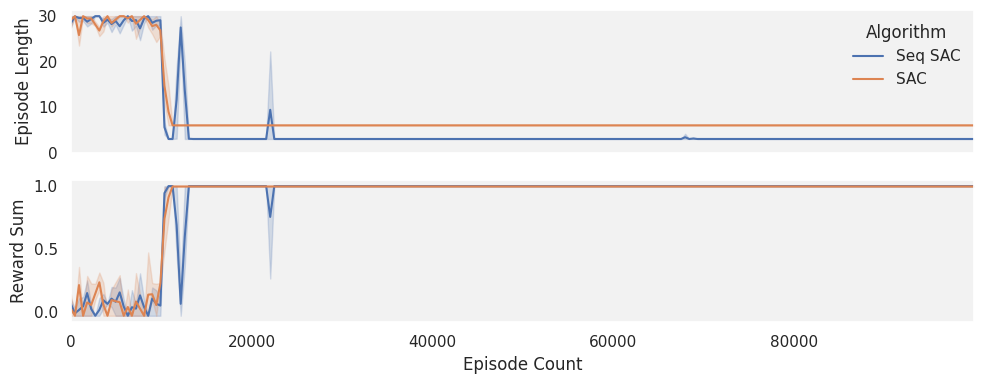

In [13]:
# sns.set_theme()
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"}) 

fig, axs = plt.subplots(2, 1, figsize=(10,4), sharex = True)

sns.lineplot(df_ep_len[df_ep_len["steps"] <= 100000], x = "steps", y = "rollout/ep_steps", hue = "run", ax = axs[0])
axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)
axs[0].set_ylabel('Episode Length')
axs[0].margins(x=0)
axs[0].set_ylim(0.)


sns.lineplot(df[df["steps"] <= 100000], x = "steps", y = "rollout/reward_sum", hue = "run", ax = axs[1], 
             legend = False)
axs[1].set_ylabel('Reward Sum')
axs[1].set_xlabel('Episode Count')
axs[1].margins(x=0)
axs[0].set_ylim(0.)


plt.tight_layout()
plt.show()

fig.savefig('plots/meeting_3_SAC.png', dpi = 300)

# 5 SAC

In [40]:

run_list = [
    "sac_5_1",
    # "sac_5_2",
    "sac_5_3",
    "seqsac_5_1",
    "seqsac_5_2",
    "seqsac_5_3",
]
tb_files = get_tb_files("meeting_training", run_list)
display(tb_files)

df_ep_len = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_steps", 450)
df_ep_len = pd.concat([df_ep_len, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/ep_len", 450)])
df = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/reward_sum", 450)
df = pd.concat([df, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/reward_sum", 450)])
# df_ep_len_wt = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_len", 3.75, True)
# df__wt = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/eval_reward_sum", 3.75, True)

['training/meeting_training/sac_5_1/tensorboard_logs/events.out.tfevents.1729306299.v100gpu13.80027.0',
 'training/meeting_training/sac_5_3/tensorboard_logs/events.out.tfevents.1729399003.v100gpu10.3565907.0',
 'training/meeting_training/seqsac_5_1/tensorboard_logs/events.out.tfevents.1729418528.v100gpu9.1968921.0',
 'training/meeting_training/seqsac_5_1/tensorboard_logs/train_avg_actor_loss_agent1/events.out.tfevents.1729418865.v100gpu9.1968921.7',
 'training/meeting_training/seqsac_5_1/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1729418528.v100gpu9.1968921.2',
 'training/meeting_training/seqsac_5_1/tensorboard_logs/train_avg_alpha_loss_agent1/events.out.tfevents.1729418865.v100gpu9.1968921.17',
 'training/meeting_training/seqsac_5_1/tensorboard_logs/train_avg_critic_loss_agent1/events.out.tfevents.1729418865.v100gpu9.1968921.12',
 'training/meeting_training/seqsac_5_1/tensorboard_logs/train_avg_alpha_agent1/events.out.tfevents.1729418865.v100gpu9.1968921.22',
 'tra

Scalar rollout/ep_steps not found.
sac_5 done!
Scalar rollout/ep_steps not found.
sac_5 done!
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar rollout/ep_steps not found.
seqsac_5 done!
Scalar roll

In [41]:
df["rollout/reward_sum"] = df["rollout/reward_sum"] / 1000 


/tmp/ipykernel_32533/3872267847.py:7: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)


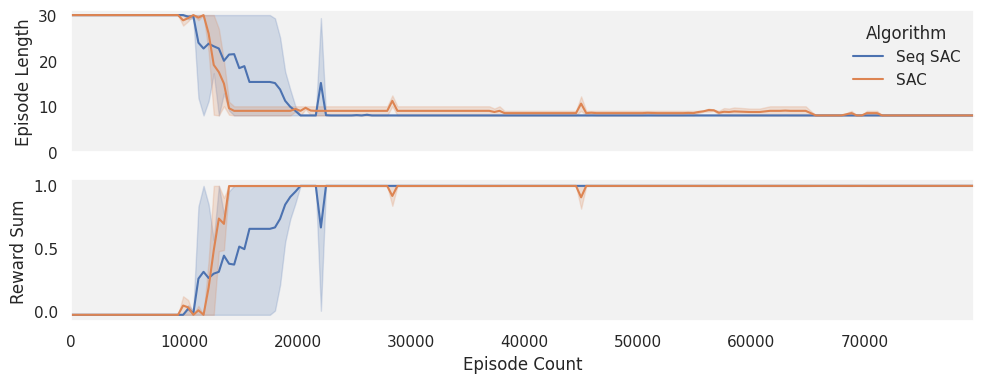

In [42]:
# sns.set_theme()
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"}) 

fig, axs = plt.subplots(2, 1, figsize=(10,4), sharex = True)

sns.lineplot(df_ep_len[df_ep_len["steps"] <= 80000], x = "steps", y = "rollout/ep_steps", hue = "run", ax = axs[0])
axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)
axs[0].set_ylabel('Episode Length')
axs[0].margins(x=0)
axs[0].set_ylim(0.)


sns.lineplot(df[df["steps"] <= 80000], x = "steps", y = "rollout/reward_sum", hue = "run", ax = axs[1], 
             legend = False)
axs[1].set_ylabel('Reward Sum')
axs[1].set_xlabel('Episode Count')
axs[1].margins(x=0)
axs[0].set_ylim(0.)


plt.tight_layout()
plt.show()

fig.savefig('plots/meeting_5_SAC.png', dpi = 300)

# 7 SAC

In [29]:

run_list = [
    "sac_7_1",
    "sac_7_2",
    "sac_7_3",
    "seqsac_7_1",
    "seqsac_7_2",
    "seqsac_7_3",
]
tb_files = get_tb_files("meeting_training", run_list)
display(tb_files)

df_ep_len = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_steps", 200)
df_ep_len = pd.concat([df_ep_len, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/ep_len", 200)])
df = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/reward_sum", 200)
df = pd.concat([df, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/reward_sum", 200)])
# df_ep_len_wt = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_len", 3.75, True)
# df__wt = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/eval_reward_sum", 3.75, True)

['training/meeting_training/sac_7_1/tensorboard_logs/events.out.tfevents.1729415705.v100gpu11.4095849.0',
 'training/meeting_training/sac_7_2/tensorboard_logs/events.out.tfevents.1729417868.v100gpu6.3680012.0',
 'training/meeting_training/seqsac_7_1/tensorboard_logs/events.out.tfevents.1729481150.v100gpu10.3583851.0',
 'training/meeting_training/seqsac_7_1/tensorboard_logs/train_avg_actor_loss_agent1/events.out.tfevents.1729481606.v100gpu10.3583851.9',
 'training/meeting_training/seqsac_7_1/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1729481151.v100gpu10.3583851.2',
 'training/meeting_training/seqsac_7_1/tensorboard_logs/train_avg_alpha_loss_agent1/events.out.tfevents.1729481606.v100gpu10.3583851.23',
 'training/meeting_training/seqsac_7_1/tensorboard_logs/train_avg_critic_loss_agent1/events.out.tfevents.1729481606.v100gpu10.3583851.16',
 'training/meeting_training/seqsac_7_1/tensorboard_logs/train_avg_alpha_agent1/events.out.tfevents.1729481606.v100gpu10.3583851.30'

Scalar rollout/ep_steps not found.
sac_7 done!
Scalar rollout/ep_steps not found.
sac_7 done!
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
seqsac_7 done!
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar rollout/ep_steps not found.
seqsac_7 done!
Scalar roll

In [30]:
df["rollout/reward_sum"] = df["rollout/reward_sum"] / 1000 

/tmp/ipykernel_32533/2356854035.py:7: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)


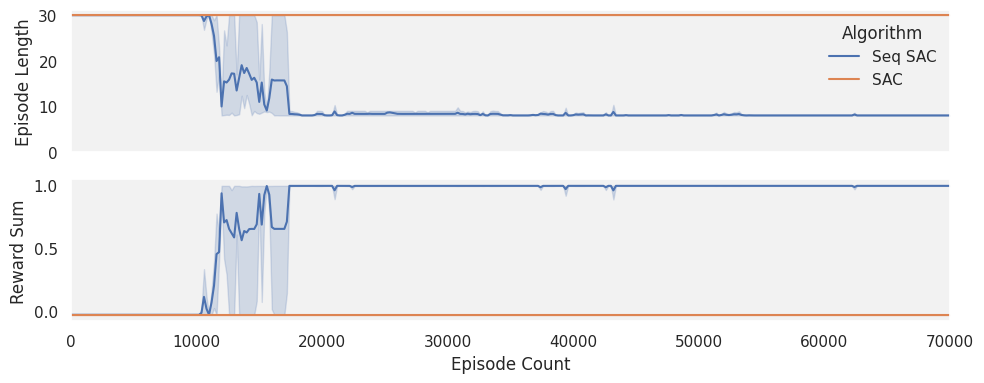

In [35]:
# sns.set_theme()
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"}) 

fig, axs = plt.subplots(2, 1, figsize=(10,4), sharex = True)

sns.lineplot(df_ep_len[df_ep_len["steps"] <= 70000], x = "steps", y = "rollout/ep_steps", hue = "run", ax = axs[0])
axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)
axs[0].set_ylabel('Episode Length')
axs[0].margins(x=0)
axs[0].set_ylim(0.)


sns.lineplot(df[df["steps"] <= 70000], x = "steps", y = "rollout/reward_sum", hue = "run", ax = axs[1], 
             legend = False)
axs[1].set_ylabel('Reward Sum')
axs[1].set_xlabel('Episode Count')
axs[1].margins(x=0)
axs[0].set_ylim(0.)


plt.tight_layout()
plt.show()

fig.savefig('plots/meeting_7_sac.png', dpi = 300)

# 3 ALL

In [20]:

run_list = [
    "sac_3_1",
    "sac_3_2",
    "sac_3_3",
    "seqsac_3_1",
    "seqsac_3_2",
    "seqsac_3_3",
]
tb_files = get_tb_files("meeting_training", run_list)
display(tb_files)

df_ep_len = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_steps", 450)
df_ep_len = pd.concat([df_ep_len, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/ep_len", 450)])
df = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/reward_sum", 450)
df = pd.concat([df, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/reward_sum", 450)])

# df_ep_len_wt = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_len", 3.75, True)
# df__wt = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/eval_reward_sum", 3.75, True)

df["rollout/reward_sum"] = df["rollout/reward_sum"] / 1000 

run_list = [
    "dqn_3_llr_50",
    "dqn_3_llr_50_1",
    "dqn_3_llr_50_2",
    "seqdqn_3_50",
    "seqdqn_3_50_2",
    "seqdqn_3_50_1",
]
tb_files = get_tb_files("meeting_training", run_list)
display(tb_files)
get_names_meeting_env(tb_files)

df_ep_len = pd.concat([df_ep_len, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/ep_len", 450)])
df = pd.concat([df, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/eval_reward_sum", 450)])

['training/meeting_training/sac_3_1/tensorboard_logs/events.out.tfevents.1729262446.v100gpu15.1007777.0',
 'training/meeting_training/sac_3_2/tensorboard_logs/events.out.tfevents.1729269402.v100gpu10.3503880.0',
 'training/meeting_training/sac_3_3/tensorboard_logs/events.out.tfevents.1729286091.v100gpu11.4033669.0',
 'training/meeting_training/seqsac_3_1/tensorboard_logs/events.out.tfevents.1729417867.v100gpu4.3755685.0',
 'training/meeting_training/seqsac_3_1/tensorboard_logs/train_avg_actor_loss_agent1/events.out.tfevents.1729418098.v100gpu4.3755685.5',
 'training/meeting_training/seqsac_3_1/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1729417868.v100gpu4.3755685.2',
 'training/meeting_training/seqsac_3_1/tensorboard_logs/train_avg_alpha_loss_agent1/events.out.tfevents.1729418098.v100gpu4.3755685.11',
 'training/meeting_training/seqsac_3_1/tensorboard_logs/train_avg_critic_loss_agent1/events.out.tfevents.1729418098.v100gpu4.3755685.8',
 'training/meeting_training/se

Scalar rollout/ep_steps not found.
sac_3 done!
Scalar rollout/ep_steps not found.
sac_3 done!
Scalar rollout/ep_steps not found.
sac_3 done!
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout/ep_steps not found.
seqsac_3 done!
Scalar rollout

['training/meeting_training/dqn_3_llr_50/tensorboard_logs/events.out.tfevents.1724937920.v100gpu11.44692.0',
 'training/meeting_training/dqn_3_llr_50_1/tensorboard_logs/events.out.tfevents.1727111932.v100gpu29.830273.0',
 'training/meeting_training/dqn_3_llr_50_2/tensorboard_logs/events.out.tfevents.1727111939.v100gpu26.3758671.0',
 'training/meeting_training/seqdqn_3_50/tensorboard_logs/events.out.tfevents.1724944405.v100gpu1.1904406.0',
 'training/meeting_training/seqdqn_3_50/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1724944408.v100gpu1.1904406.2',
 'training/meeting_training/seqdqn_3_50/tensorboard_logs/train_avg_Q_target_value_agent1/events.out.tfevents.1724944408.v100gpu1.1904406.11',
 'training/meeting_training/seqdqn_3_50/tensorboard_logs/train_avg_Q_value_agent1/events.out.tfevents.1724944408.v100gpu1.1904406.8',
 'training/meeting_training/seqdqn_3_50/tensorboard_logs/train_average_loss_agent1/events.out.tfevents.1724944408.v100gpu1.1904406.5',
 'training/

dqn_3_llr_50 done!
dqn_3_llr_50 done!
dqn_3_llr_50 done!
seqdqn_3_50 done!
Scalar rollout/ep_len not found.
seqdqn_3_50 done!
Scalar rollout/ep_len not found.
seqdqn_3_50 done!
Scalar rollout/ep_len not found.
seqdqn_3_50 done!
Scalar rollout/ep_len not found.
seqdqn_3_50 done!
seqdqn_3_50 done!
Scalar rollout/ep_len not found.
seqdqn_3_50 done!
Scalar rollout/ep_len not found.
seqdqn_3_50 done!
seqdqn_3_50 done!
Scalar rollout/ep_len not found.
seqdqn_3_50 done!
Scalar rollout/ep_len not found.
seqdqn_3_50 done!
dqn_3_llr_50 done!
dqn_3_llr_50 done!
dqn_3_llr_50 done!
seqdqn_3_50 done!
Scalar rollout/eval_reward_sum not found.
seqdqn_3_50 done!
Scalar rollout/eval_reward_sum not found.
seqdqn_3_50 done!
Scalar rollout/eval_reward_sum not found.
seqdqn_3_50 done!
Scalar rollout/eval_reward_sum not found.
seqdqn_3_50 done!
seqdqn_3_50 done!
Scalar rollout/eval_reward_sum not found.
seqdqn_3_50 done!
Scalar rollout/eval_reward_sum not found.
seqdqn_3_50 done!
seqdqn_3_50 done!
Scalar rol

In [26]:
df = df[df["steps"] < 100000]
df_ep_len = df_ep_len[df_ep_len["steps"] < 100000]
df = df.reindex()

/tmp/ipykernel_32533/2314707970.py:7: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq SAC", "_nolegend_", "SAC", "_nolegend_", "DQN", "_nolegend_", "Seq DQN" ], frameon = False)


ValueError: cannot reindex on an axis with duplicate labels

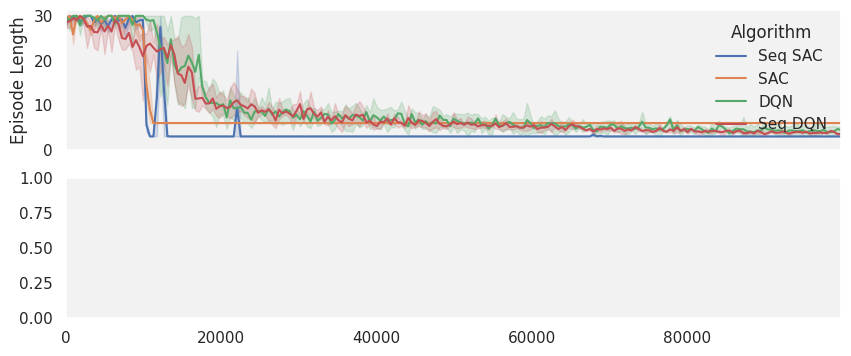

In [28]:
# sns.set_theme()
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"}) 

fig, axs = plt.subplots(2, 1, figsize=(10,4), sharex = True)

sns.lineplot(df_ep_len, x = "steps", y = "rollout/ep_steps", hue = "run", ax = axs[0])
axs[0].legend(title = "Algorithm", loc = "upper right", labels = ["Seq SAC", "_nolegend_", "SAC", "_nolegend_", "DQN", "_nolegend_", "Seq DQN" ], frameon = False)
axs[0].set_ylabel('Episode Length')
axs[0].margins(x=0)
axs[0].set_ylim(0.)


sns.lineplot(df, x = "steps", y = "rollout/eval_reward_sum", hue = "run", ax = axs[1], 
             legend = False)
axs[1].set_ylabel('Reward Sum')
axs[1].set_xlabel('Episode Count')
axs[1].margins(x=0)
axs[0].set_ylim(0.)


plt.tight_layout()
plt.show()

fig.savefig('plots/meeting_3_DQN.png', dpi = 300)